# Task 7 - Stock Prices Predictions using Numerical and Textual Data

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web_data
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima.utils import ndiffs


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

## Stock Prices Data Analysis

In [3]:
NAME = "GOOG"
DATA_SOURCE = "yahoo"

## this start and end dates came from the textual dataset.
START = datetime.date(2001, 1, 2 )
END   = datetime.date(2022, 3, 31)

In [4]:
stock_data = web_data.DataReader(name=NAME, data_source=DATA_SOURCE, start=START, end=END)
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,2.591785,2.390042,2.490664,2.499133,897427216.0,2.499133
2004-08-23,2.826406,2.716070,2.758411,2.724787,366857939.0,2.724787
2004-08-24,2.779581,2.579581,2.770615,2.611960,306396159.0,2.611960
2004-08-25,2.689918,2.587302,2.614201,2.640104,184645512.0,2.640104
2004-08-26,2.688672,2.606729,2.613952,2.687676,142572401.0,2.687676


In [5]:
stock_data = stock_data.reset_index()
stock_data.to_csv(f"{NAME}.csv", index=False)

stock_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,2.591785,2.390042,2.490664,2.499133,897427216.0,2.499133
1,2004-08-23,2.826406,2.716070,2.758411,2.724787,366857939.0,2.724787
2,2004-08-24,2.779581,2.579581,2.770615,2.611960,306396159.0,2.611960
3,2004-08-25,2.689918,2.587302,2.614201,2.640104,184645512.0,2.640104
4,2004-08-26,2.688672,2.606729,2.613952,2.687676,142572401.0,2.687676


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3635 non-null   datetime64[ns]
 1   High       3635 non-null   float64       
 2   Low        3635 non-null   float64       
 3   Open       3635 non-null   float64       
 4   Close      3635 non-null   float64       
 5   Volume     3635 non-null   float64       
 6   Adj Close  3635 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 198.9 KB


In [7]:
assert stock_data.isna().sum().sum() == 0

In [8]:
new_colnames = list(map(lambda c: c.lower().replace(" ", "_"), stock_data.columns))
stock_data.columns = new_colnames

stock_data.head(3)

,date,high,low,open,close,volume,adj_close
0,2004-08-19,2.591785,2.390042,2.490664,2.499133,897427216.0,2.499133
1,2004-08-23,2.826406,2.716070,2.758411,2.724787,366857939.0,2.724787
2,2004-08-24,2.779581,2.579581,2.770615,2.611960,306396159.0,2.611960


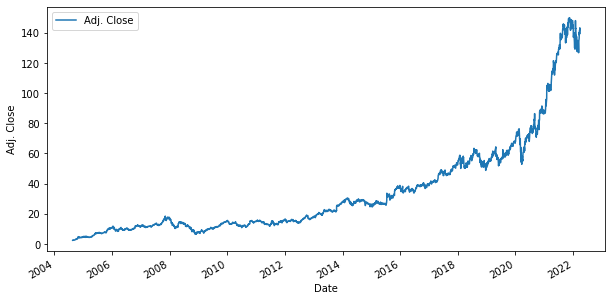

In [9]:
stock_data.plot(x="date", y="adj_close", figsize=(10, 5),
                xlabel="Date", ylabel="Adj. Close", label="Adj. Close");

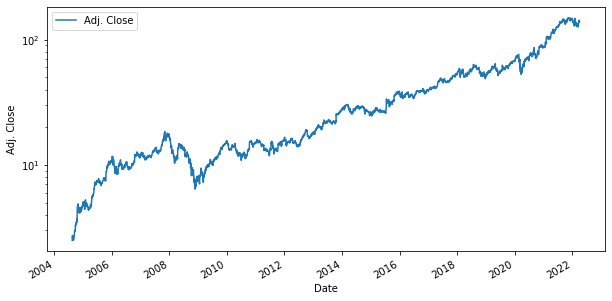

In [10]:
ax = stock_data.plot(x="date", y="adj_close", figsize=(10, 5),
                xlabel="Date", ylabel="Adj. Close", label="Adj. Close")
plt.yscale("log");

After we apply the Log Scale at the y-axis we can clearly see the data points more easly and we can interpret it more easly. As we can see there is a very bad drop in the price at the interval from **2008** to **2009** and is proberly has something to do with the **Inflation Cricis** that occured at that interval of time where is was a very bad drop in the prices in all stock markets.

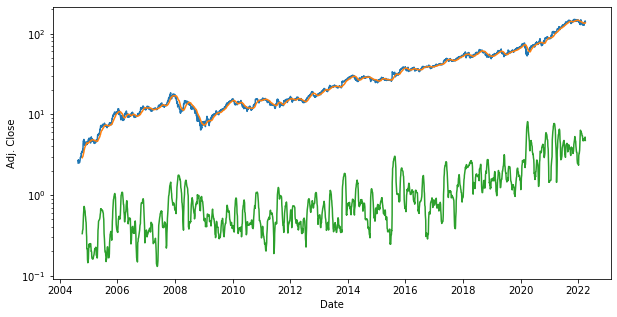

In [11]:
stock_data["roll_30_mean"] = stock_data["adj_close"].rolling(30).mean()
stock_data["roll_30_std"]  = stock_data["adj_close"].rolling(30).std()

fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
sns.lineplot(x="date", y="adj_close", data=stock_data, ax=ax)
sns.lineplot(x="date", y="roll_30_mean", data=stock_data, ax=ax)
sns.lineplot(x="date", y="roll_30_std", data=stock_data, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Date")
ax.set_ylabel("Adj. Close");

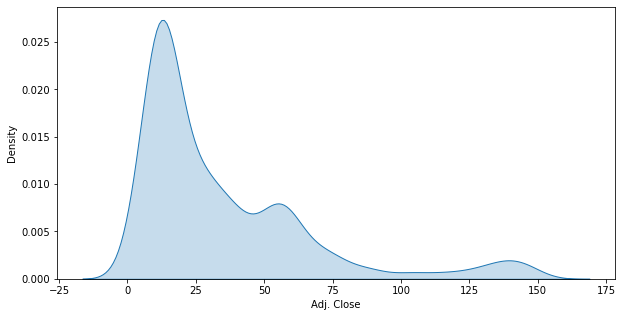

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(x="adj_close", data=stock_data, shade=True)
plt.xlabel("Adj. Close");

In [13]:
stock_data[["close", "adj_close"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
close,3635.0,34.866792,32.649732,2.496891,12.418452,21.927061,51.024752,149.952499
adj_close,3635.0,34.866792,32.649732,2.496891,12.418452,21.927061,51.024752,149.952499


In [14]:
(stock_data["close"] == stock_data["adj_close"]).all()

True

In [15]:
adfuller_results = adfuller(stock_data["adj_close"], autolag="t-stat")

print("Critical Value = {:.4f}".format(adfuller_results[0]))
print("P Value = {:.4f}".format(adfuller_results[1]))
print("Number of Lags Needed = {:2d}".format(adfuller_results[2]))

print("\nT Statistics of the Data at Different CL")
for k, v in adfuller_results[4].items():
    print("Critical at [{:>3s}] = {:>8.4f}".format(k, v))
    

Critical Value = 2.9987
P Value = 1.0000
Number of Lags Needed = 30

T Statistics of the Data at Different CL
Critical at [ 1%] =  -3.4322
Critical at [ 5%] =  -2.8623
Critical at [10%] =  -2.5672


Since the **Critical Value** of the Data is **Greater** the all the **T Values at (1%, 5%, 10%)**. We can say that we **Fail to Regect the Null Hypothesis**. And Hence The Data **Don't Contain stationarity Points**. Also because the **P Value** is Greater than the 5% Confidance Level of (95% Confidance Interval). We also can say that we **Fail to Regect the Null Hypothesis $H_0$**

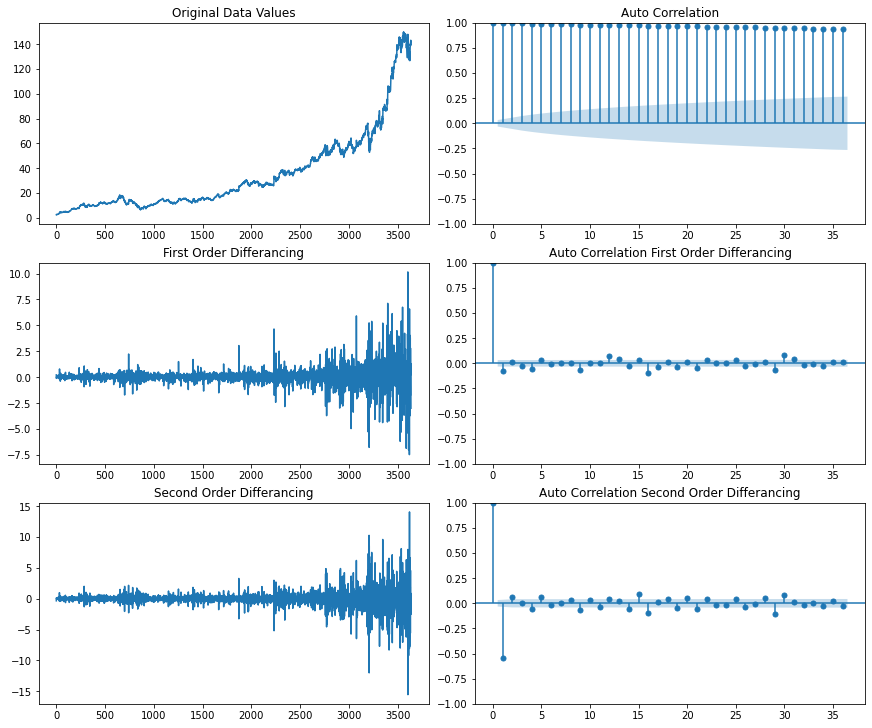

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), constrained_layout=True)

axes[0, 0].plot(stock_data["adj_close"])
axes[0, 0].set_title("Original Data Values")
plot_acf(stock_data["adj_close"], ax=axes[0, 1])
axes[0, 1].set_title("Auto Correlation")

axes[1, 0].plot(stock_data["adj_close"].diff())
axes[1, 0].set_title("First Order Differancing")
plot_acf(stock_data["adj_close"].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title("Auto Correlation First Order Differancing")

axes[2, 0].plot(stock_data["adj_close"].diff().diff())
axes[2, 0].set_title("Second Order Differancing")
plot_acf(stock_data["adj_close"].diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title("Auto Correlation Second Order Differancing")

plt.show()

In [17]:
d = ndiffs(stock_data["adj_close"], test="adf")
print("No. of Differences = {:2d}".format(d))

No. of Differences =  1


From the figure above we can see that the data has reaches stationarity after the **first** differancing as after the second it also improved a little but not much and slos it going to nigative region so it not very good to consider so we will got with differnaceing of the first order.

And on top of that using the `ndiffs` from the `pmdarima` library shows that we need only the first differances in order to reach to stationarity using the `adfuller` test.

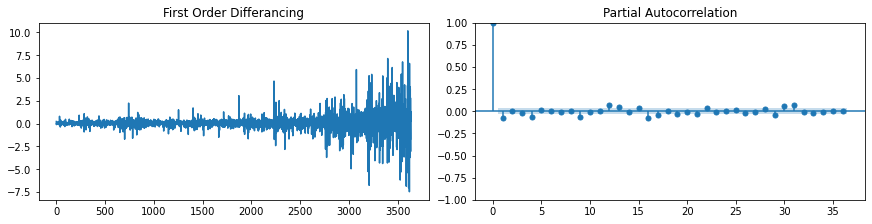

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True)

axes[0].plot(stock_data["adj_close"].diff().dropna())
axes[0].set_title("First Order Differancing")
plot_pacf(stock_data["adj_close"].diff().dropna(), method='ywm', ax=axes[1])
plt.show()

## Stock Prices Modeling (Forecasting)

In [19]:
d = 1
p = 2
q = 0

model = ARIMA(stock_data["adj_close"].values, order=(d, p, q))
model_fitted = model.fit()

model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3635
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -5495.804
Date:                Sat, 05 Nov 2022   AIC                          10995.608
Time:                        16:14:57   BIC                          11008.004
Sample:                             0   HQIC                         11000.023
                               - 3635                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5425      0.005   -102.007      0.000      -0.553      -0.532
sigma2         1.2062      0.010    126.484      0.000       1.188       1.225
===================================================================================
Ljung-Box (L1) (Q):                 117.80   Jarque-Bera (JB):             43212.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              30.43   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

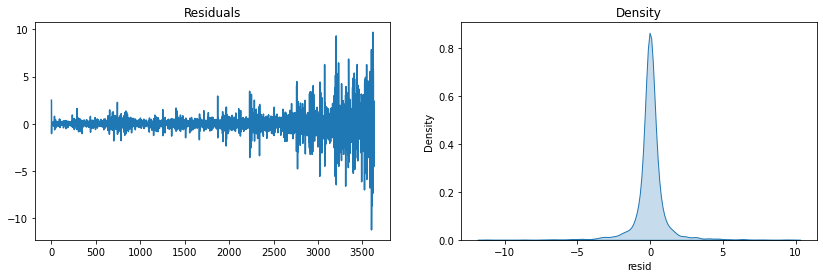

In [20]:
residuals = pd.DataFrame({"resid": model_fitted.resid})

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
axes[0].plot(residuals["resid"])
axes[0].set_title("Residuals")
sns.kdeplot(x="resid", data=residuals, shade=True, ax=axes[1])
axes[1].set_title("Density");

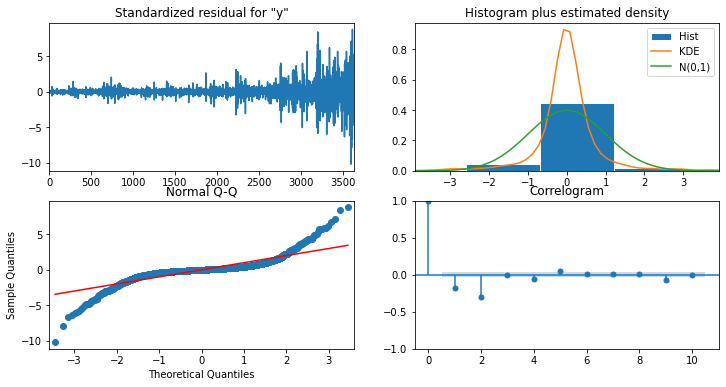

In [21]:
model_fitted.plot_diagnostics(figsize=(12, 6))
plt.show()

In [22]:
model_fitted.forecast(15, alpha=0.05)

array([137.95069508, 135.54876783, 133.52824699, 131.30083184,
       129.18564673, 127.00958231, 124.86654194, 122.70558764,
       120.55435077, 118.39784267, 116.24419395, 114.08899416,
       111.93463575, 109.77982093, 107.62525369])

In [23]:
TRAIN_SIZE = int(stock_data.shape[0] * 0.9)
train_data = stock_data["adj_close"].loc[:TRAIN_SIZE]
valid_data = stock_data["adj_close"].loc[TRAIN_SIZE:]

print("Training Data Shape : ", train_data.shape)
print("Validation Data Shape : ", valid_data.shape)

Training Data Shape :  (3272,)
Validation Data Shape :  (364,)


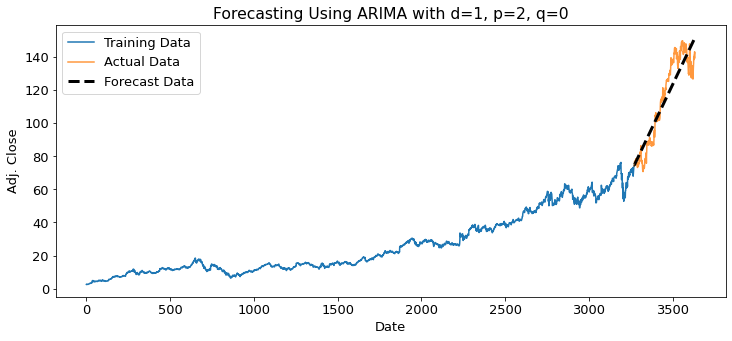

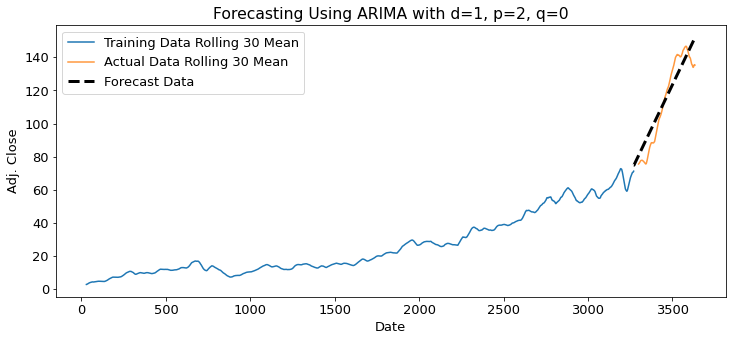

In [24]:
d = 1
p = 2
q = 0

## Train ARIMA Model
model = ARIMA(train_data, order=(d, p, q))
model_fitted = model.fit()

## Forecast
forecast = model_fitted.forecast(valid_data.shape[0], alpha=0.05)

plt.rcParams["font.size"] = 13
plt.figure(figsize=(12, 5))
plt.plot(train_data, label="Training Data")
plt.plot(valid_data, alpha=0.8, label="Actual Data")
plt.plot(forecast, lw=3, color="k", ls="--", label="Forecast Data")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.title("Forecasting Using ARIMA with d={}, p={}, q={}".format(d, p, q));

ROLLING = 30

plt.figure(figsize=(12, 5))
plt.plot(pd.Series(train_data).rolling(ROLLING).mean(), label="Training Data Rolling 30 Mean")
plt.plot(pd.Series(valid_data).rolling(ROLLING).mean().dropna(), alpha=0.8, label="Actual Data Rolling 30 Mean")
plt.plot(forecast, lw=3, color="k", ls="--", label="Forecast Data")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.title("Forecasting Using ARIMA with d={}, p={}, q={}".format(d, p, q));

As we can see from the figures above the **Forecast** is very close to the actual data in the **Adj. Close** and it is even more close when apply a moving average of 30. ARIMA Models showed that it is can be very good when forecasting if we find the right parameters `d, p, q` which have values of `1, 2, 0` respectivly.

## Textual Data Analysis

In [25]:
text_data = pd.read_csv("india-news-headlines.csv")
text_data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [26]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [27]:
text_data["publish_date"] = pd.to_datetime(text_data["publish_date"])
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [28]:
assert text_data.isna().sum().sum() == 0

In [29]:
text_data["headline_length"] = text_data["headline_text"].str.len()

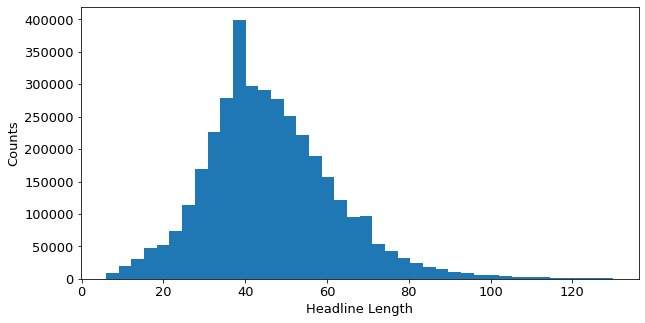

In [30]:
ax = text_data["headline_length"].hist(figsize=(10, 5), grid=False, bins=40)
ax.set_xlabel("Headline Length")
ax.set_ylabel("Counts");

In [31]:
categories = text_data["headline_category"].unique()
categories

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [32]:
categories.shape[0]

1041

india                            0.081483
unknown                          0.057405
city.mumbai                      0.041209
city.delhi                       0.037702
business.india-business          0.033195
city.hyderabad                   0.032601
city.chandigarh                  0.032243
city.bengaluru                   0.027016
city.pune                        0.027016
city.ahmedabad                   0.026916
city.kolkata                     0.025741
entertainment.hindi.bollywood    0.025500
city.lucknow                     0.025134
city.goa                         0.024371
city.nagpur                      0.023979
city.patna                       0.022086
city.chennai                     0.021707
city.jaipur                      0.018143
home.campaigns                   0.013324
sports.icc-world-cup-2015        0.011165
Name: headline_category, dtype: float64


<AxesSubplot:>

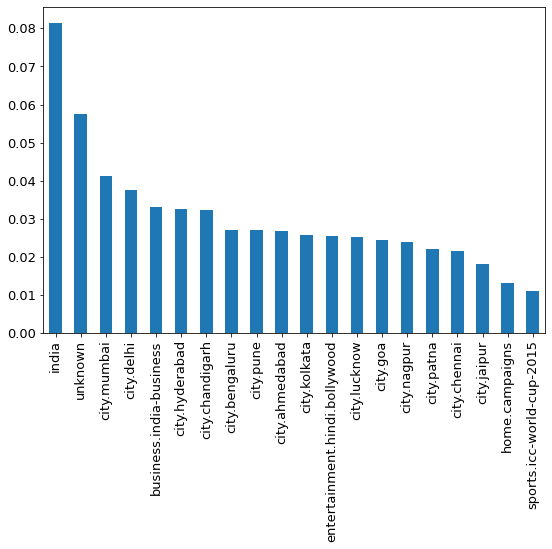

In [33]:
categories_counts = (
    text_data["headline_category"].value_counts(normalize=True)
    .sort_values(ascending=False).iloc[:20]
)
print(categories_counts)

categories_counts.plot.bar(figsize=(9, 6))

**Note :**
 - **Due to my laptop has week performance I was not able to complete the Textual Analysis as it was able to handle that data and fit it in memory.**